## - **Dazzle A J   21MIA1119**
## - **Shashank Singh  21MIA1110**
## - **Dishant Naik    21MIA1127**



In [ ]:
import numpy as np
import pandas as pd
data=pd.read_csv("/content/data1.csv")
data.duplicated().sum()

0

## Using the Power of NLP(BERT Embeddings and Annoy) to Recommend Simmilar Products to overcome the Problem of Cold-Start Problem
Cold Start Problem: This constitutes a problem mainly for collaborative filtering algorithms due to the fact that they rely on the item's interactions to make recommendations.for that case we can leverage the capability of NLP to recommend the more simmilar products for the new user as there is no interaction with any of our products or byuing patterns of the user in the platform due to this to make more reliable recommendation we can use this.

In [ ]:
'''import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import transformers
import torch
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
%matplotlib inline'''

'import tensorflow as tf\nfrom tensorflow import keras\nimport pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport time\nimport pickle\nfrom keras import backend as K\nimport tensorflow as tf\nfrom tensorflow.keras.utils import to_categorical\nimport transformers\nimport torch\nimport warnings\nwarnings.filterwarnings("ignore")\nwarnings.simplefilter(\'ignore\')\n%matplotlib inline'

In [ ]:
'''df_products = pd.read_csv('products.csv')

df_products.head()'''

"df_products = pd.read_csv('products.csv')\n\ndf_products.head()"

In [ ]:
'''#bert large uncased pretrained tokenizer
pretrained_weights = 'distilbert-base-uncased'
# Load pretrained model/tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained(pretrained_weights)'''

"#bert large uncased pretrained tokenizer\npretrained_weights = 'distilbert-base-uncased'\n# Load pretrained model/tokenizer\ntokenizer = transformers.DistilBertTokenizer.from_pretrained(pretrained_weights)"

In [ ]:
'''tokenized = df_products.product_name.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))'''

'tokenized = df_products.product_name.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))'

In [ ]:
'''tokenized'''

'tokenized'

In [ ]:
'''dict(zip(tokenizer.all_special_tokens,tokenizer.all_special_ids))'''

'dict(zip(tokenizer.all_special_tokens,tokenizer.all_special_ids))'

In [ ]:
'''print(tokenized[0:2])'''

'print(tokenized[0:2])'

In [ ]:
'''#Later we will only average those tokens embeddings
text_len = [len(v) for v in tokenized]
text_len[:5]'''

'#Later we will only average those tokens embeddings\ntext_len = [len(v) for v in tokenized]\ntext_len[:5]'

In [ ]:
'''#limit the maxlen to 20
maxlen = 20
for ix,token in enumerate(tokenized):
    if len(token) >= maxlen:
        token = token[:maxlen]
    else:
        token = token + [0] * (maxlen-len(token))
    tokenized[ix] = list(token)'''

'#limit the maxlen to 20\nmaxlen = 20\nfor ix,token in enumerate(tokenized):\n    if len(token) >= maxlen:\n        token = token[:maxlen]\n    else:\n        token = token + [0] * (maxlen-len(token))\n    tokenized[ix] = list(token)'

In [ ]:
'''tokenized = np.array(list(tokenized))
tokenized.shape'''

'tokenized = np.array(list(tokenized))\ntokenized.shape'

In [ ]:
'''print(tokenized[0:2])'''

'print(tokenized[0:2])'

In [ ]:
'''bert_model = transformers.TFDistilBertModel.from_pretrained(pretrained_weights)
bert_model.summary()'''


'bert_model = transformers.TFDistilBertModel.from_pretrained(pretrained_weights)\nbert_model.summary()'

In [ ]:
'''# Creatinga hashmap and map the productId to each their product id's
product_ids = list(df_products.product_id)
product_name = list(df_products.product_name)

product_map = {}
for i in range(len(product_ids)):
    product_map[product_ids[i]] = product_name[i]'''

"# Creatinga hashmap and map the productId to each their product id's\nproduct_ids = list(df_products.product_id)\nproduct_name = list(df_products.product_name)\n\nproduct_map = {}\nfor i in range(len(product_ids)):\n    product_map[product_ids[i]] = product_name[i]"

In [ ]:
'''len(set(product_ids)),len(set(product_name))'''

'len(set(product_ids)),len(set(product_name))'

In [ ]:
'''product_map[1]'''

'product_map[1]'

In [ ]:
'''product_ids[:5], product_name[:5]'''

'product_ids[:5], product_name[:5]'

In [ ]:
'''def compress_tokens_embedding(arr,k,step):
    output = []
    r = arr.shape[0] # index No of product descriptions
    c = arr.shape[2] # Embedding size which is of 768 dimension
    for i in range(r):
        tmp = [product_ids[k+i],product_name[k+i]]
        x = np.mean( np.array(arr[i])[:text_len[k+i],:], axis = 0)
        for j in range(0,c,step): #Compression
            tmp.append(np.mean(x[j:j+step]))
        output.append(tmp)
    return np.array(output)'''

'def compress_tokens_embedding(arr,k,step):\n    output = []\n    r = arr.shape[0] # index No of product descriptions\n    c = arr.shape[2] # Embedding size which is of 768 dimension\n    for i in range(r):\n        tmp = [product_ids[k+i],product_name[k+i]]\n        x = np.mean( np.array(arr[i])[:text_len[k+i],:], axis = 0)\n        for j in range(0,c,step): #Compression\n            tmp.append(np.mean(x[j:j+step]))\n        output.append(tmp)\n    return np.array(output)'

* Since we have 49.6K products & 49.6k * 768 dimension embedding becomes a lot to keep in memory, we process in batches.

* In first approach we will use the obtained hidden vector representation of all the tokens and do average pooling to get 768-dimension embedding ignoring the padded tokens.

* We will then compress the 768-dimension embedding to 64-dimensional by pooling across dimensions.

In [ ]:
'''#as we run our model to generate the embeddings of products into batch of 80 so this is no of files we can get
49688/80'''

'#as we run our model to generate the embeddings of products into batch of 80 so this is no of files we can get\n49688/80'

In [ ]:
'''# code to store the product description in batch of 80 and store in 49688//80 = 621 different files and store the file using mean_avg_pooling technique
input_ids = tokenized
embedding_size = 768
step = 80
k = 0
avg_bits = 12
file_counter = 0
compressed_embedding_size = embedding_size//avg_bits  #64-dimensional embedding
# with strategy.scope():
while k < input_ids.shape[0]:
    last_hidden_states = bert_model(input_ids[k:k+step])[0][:,1:maxlen+1,:] #First token to 20th (max-len) token
    output = compress_tokens_embedding(np.array(last_hidden_states),k,avg_bits)
    col = ['product_id','product_name'] + [str(v) for v in range(compressed_embedding_size)]
    df_output = pd.DataFrame(output,columns = col)
    df_output.to_csv('file_' + str(file_counter) + '.csv', header = True, index=False)
    file_counter += 1
    k += step'''

"# code to store the product description in batch of 80 and store in 49688//80 = 621 different files and store the file using mean_avg_pooling technique\ninput_ids = tokenized\nembedding_size = 768\nstep = 80\nk = 0\navg_bits = 12\nfile_counter = 0\ncompressed_embedding_size = embedding_size//avg_bits  #64-dimensional embedding\n# with strategy.scope():\nwhile k < input_ids.shape[0]:\n    last_hidden_states = bert_model(input_ids[k:k+step])[0][:,1:maxlen+1,:] #First token to 20th (max-len) token\n    output = compress_tokens_embedding(np.array(last_hidden_states),k,avg_bits)\n    col = ['product_id','product_name'] + [str(v) for v in range(compressed_embedding_size)]\n    df_output = pd.DataFrame(output,columns = col)\n    df_output.to_csv('file_' + str(file_counter) + '.csv', header = True, index=False)\n    file_counter += 1\n    k += step"

bert_model(input_ids[k:k+step]): This part passes a batch of tokenized IDs to the BERT model. k is the starting index of the batch, and k+step is the ending index. So, input_ids[k:k+step] selects a batch of tokenized IDs.
[0]: This retrieves the output of the BERT model. BERT typically returns a tuple, and the first element of the tuple contains the output hidden states.
[:,1:maxlen+1,:]: This slices the output hidden states. The first dimension : refers to all samples in the batch, 1:maxlen+1 refers to selecting tokens from the first token to the 20th token (maxlen is used as the upper bound because Python slicing is exclusive at the end), and : in the last dimension refers to all hidden dimensions.

In [ ]:
'''input_ids[0:0+1]'''

'input_ids[0:0+1]'

In [ ]:
'''last_hidden_states = bert_model(input_ids[0:0+1])[0][:,1:maxlen+1,:]'''

'last_hidden_states = bert_model(input_ids[0:0+1])[0][:,1:maxlen+1,:]'

In [ ]:
'''#last_hidden_states comprised of 1st products description into 768 vectors dimension which we performed man pooling
t=np.array(last_hidden_states)'''

'#last_hidden_states comprised of 1st products description into 768 vectors dimension which we performed man pooling\nt=np.array(last_hidden_states)'

In [ ]:
'''t.shape'''

't.shape'

In [ ]:
'''!ls file*.csv | wc'''

'!ls file*.csv | wc'

In [ ]:
'''!ls file*.csv'''

'!ls file*.csv'

In [ ]:
'''chk=pd.read_csv('file_0.csv')
chk.shape'''

"chk=pd.read_csv('file_0.csv')\nchk.shape"

In [ ]:
'''# This is how abg_embedding of products look like
chk.head()'''

'# This is how abg_embedding of products look like\nchk.head()'

### Using annoy package we are trying to find the top K most nearest neighbour by leveraging the Products Embeddings
*** Below is the function to generate the Most Relatable Products(nearest, simmilar products) that we can use for recommendation in our Final Inference Pipeline**


In [ ]:
'''pip install annoy'''

'pip install annoy'

In [ ]:
'''from annoy import AnnoyIndex
def create_index_find_similar_items(files):
    dfs = []
    for i in range(files):
        dfs.append(pd.read_csv('file_'+ str(i)+'.csv'))
    df_embedding = pd.concat(dfs)
    dfs.append(pd.read_csv('file_'+ str(i)+'.csv'))
    embedding_size = compressed_embedding_size
    a = AnnoyIndex(embedding_size, 'euclidean')
    for ix,row in df_embedding.iterrows():
        key = int(row['product_id'])
        vec = list(row[[str(v) for v in range(compressed_embedding_size)]])
        a.add_item(key,vec)

    a.build(100) # 100 trees
    a.save('test.tree')
    u = AnnoyIndex(embedding_size,  'euclidean')
    u.load('test.tree')

    top_k = 20
    mat = []
    for ix,row in df_embedding.iterrows():
        item = int(row['product_id'])
        mat.append([item] + u.get_nns_by_item(item, top_k+1)[1:])

#     print(len(mat),len(mat[0]))

    cols = ['product_id']
    for i in range(top_k):
        cols += ['nearest_{}'.format(i+1)]
    print(cols)

    df_neighbors1 = pd.DataFrame(mat, columns = cols)

    df_neighbors2 = df_neighbors1.copy()

    for c in cols:
        df_neighbors2[c] = df_neighbors2[c].apply(lambda v : product_map[v])

    return df_neighbors2
'''

"from annoy import AnnoyIndex\ndef create_index_find_similar_items(files):\n    dfs = []\n    for i in range(files):\n        dfs.append(pd.read_csv('file_'+ str(i)+'.csv'))\n    df_embedding = pd.concat(dfs)\n    dfs.append(pd.read_csv('file_'+ str(i)+'.csv'))\n    embedding_size = compressed_embedding_size\n    a = AnnoyIndex(embedding_size, 'euclidean')\n    for ix,row in df_embedding.iterrows():\n        key = int(row['product_id'])\n        vec = list(row[[str(v) for v in range(compressed_embedding_size)]])\n        a.add_item(key,vec)\n\n    a.build(100) # 100 trees\n    a.save('test.tree')\n    u = AnnoyIndex(embedding_size,  'euclidean')\n    u.load('test.tree')\n\n    top_k = 20\n    mat = []\n    for ix,row in df_embedding.iterrows():\n        item = int(row['product_id'])\n        mat.append([item] + u.get_nns_by_item(item, top_k+1)[1:])\n\n#     print(len(mat),len(mat[0]))\n\n    cols = ['product_id']\n    for i in range(top_k):\n        cols += ['nearest_{}'.format(i+1)]\n

In [ ]:
'''df_neighbors = create_index_find_similar_items(files= 622)'''

'df_neighbors = create_index_find_similar_items(files= 622)'

In [ ]:
'''df_neighbors.head(10)'''

'df_neighbors.head(10)'

Now we are trying our Idea of a collaborative model with some random dataset which has a artifically made ratings.

In [ ]:
'''# Import libraries
import pandas as pd
import numpy as np
import transformers
from annoy import AnnoyIndex

# Load e-commerce dataset
df_ecommerce = pd.read_csv("/content/Book1.csv")

# Preprocess the dataset if needed

# Collaborative Filtering Setup
user_item_matrix = pd.pivot_table(df_ecommerce, values='Ratings', index='CustomerID', columns='StockCode').fillna(0)

# BERT Embeddings Setup
pretrained_weights = 'distilbert-base-uncased'
tokenizer = transformers.DistilBertTokenizer.from_pretrained(pretrained_weights)
bert_model = transformers.TFDistilBertModel.from_pretrained(pretrained_weights)

df_ecommerce['Description'] = df_ecommerce['Description'].fillna('')

# Create BERT embeddings for product descriptions
tokenized_descriptions = df_ecommerce.Description.apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
maxlen = 20  # Adjust maxlen as needed based on the maximum sequence length supported by your BERT model
for i, token in enumerate(tokenized_descriptions):
    if len(token) >= maxlen:
        token = token[:maxlen]
    else:
        token = token + [0] * (maxlen - len(token))
    tokenized_descriptions[i] = list(token)
tokenized_descriptions = np.array(list(tokenized_descriptions))

# Generate Recommendations
def generate_recommendations(user_id, top_n):
    # Collaborative Filtering Recommendations
    user_interactions = user_item_matrix.loc[user_id]
    collaborative_recommendations = user_interactions[user_interactions == 0].index.tolist()[:top_n]

    # BERT Embeddings-based Recommendations
    product_ids = df_ecommerce.StockCode.tolist()
    description_embeddings = get_bert_embeddings(tokenized_descriptions)
    annoy_index = build_annoy_index(description_embeddings)

    bert_embeddings_recommendations = []
    for item_id in collaborative_recommendations:
        idx = product_ids.index(item_id)
        similar_items = annoy_index.get_nns_by_vector(description_embeddings[idx], top_n + 1)[1:]
        similar_item_ids = [product_ids[i] for i in similar_items]
        bert_embeddings_recommendations.extend(similar_item_ids)

    # Combine Recommendations
    combined_recommendations = collaborative_recommendations + bert_embeddings_recommendations
    combined_recommendations = list(set(combined_recommendations))[:top_n]

    return combined_recommendations

# Function to get BERT embeddings
def get_bert_embeddings(input_ids):
    last_hidden_states = bert_model(input_ids)[0][:, 1:maxlen + 1, :]
    return np.mean(last_hidden_states.numpy(), axis=1)

# Function to build Annoy index
def build_annoy_index(embeddings):
    embedding_size = embeddings.shape[1]
    t = AnnoyIndex(embedding_size, 'euclidean')
    for i, embedding in enumerate(embeddings):
        t.add_item(i, embedding)
    t.build(100)  # 100 trees
    return t

# Example Usage
user_id = 17850  # Replace '12345' with the actual user ID
top_n = 10
recommended_items = generate_recommendations(user_id, top_n)
print("Combined Recommendations:", recommended_items)'''


'# Import libraries\nimport pandas as pd\nimport numpy as np\nimport transformers\nfrom annoy import AnnoyIndex\n\n# Load e-commerce dataset\ndf_ecommerce = pd.read_csv("/content/Book1.csv")\n\n# Preprocess the dataset if needed\n\n# Collaborative Filtering Setup\nuser_item_matrix = pd.pivot_table(df_ecommerce, values=\'Ratings\', index=\'CustomerID\', columns=\'StockCode\').fillna(0)\n\n# BERT Embeddings Setup\npretrained_weights = \'distilbert-base-uncased\'\ntokenizer = transformers.DistilBertTokenizer.from_pretrained(pretrained_weights)\nbert_model = transformers.TFDistilBertModel.from_pretrained(pretrained_weights)\n\ndf_ecommerce[\'Description\'] = df_ecommerce[\'Description\'].fillna(\'\')\n\n# Create BERT embeddings for product descriptions\ntokenized_descriptions = df_ecommerce.Description.apply(lambda x: tokenizer.encode(x, add_special_tokens=True))\nmaxlen = 20  # Adjust maxlen as needed based on the maximum sequence length supported by your BERT model\nfor i, token in enume

In [ ]:
'''import pandas as pd

# Load ground truth data
ground_truth_df = pd.read_csv("/content/imp.csv")  # Replace "imp.csv" with the actual file path
# Assuming ground truth data columns are named 'CustomerID' and 'StockCode'

# Sample combined recommendations from your code
combined_recommendations = recommended_items  # Replace with the actual combined recommendations generated by your code

# Filter ground truth data for the specific user
user_id = 17850
ground_truth_user = ground_truth_df[ground_truth_df['CustomerID'] == user_id]['StockCode'].tolist()

# Count the number of recommendations from combined recommendations that are present in the ground truth
matching_recommendations = len(set(combined_recommendations) & set(ground_truth_user))

# Calculate accuracy
total_recommendations = len(combined_recommendations)
accuracy = matching_recommendations / total_recommendations

print("Accuracy: {:.2f}".format(accuracy))'''


'import pandas as pd\n\n# Load ground truth data\nground_truth_df = pd.read_csv("/content/imp.csv")  # Replace "imp.csv" with the actual file path\n# Assuming ground truth data columns are named \'CustomerID\' and \'StockCode\'\n\n# Sample combined recommendations from your code\ncombined_recommendations = recommended_items  # Replace with the actual combined recommendations generated by your code\n\n# Filter ground truth data for the specific user\nuser_id = 17850\nground_truth_user = ground_truth_df[ground_truth_df[\'CustomerID\'] == user_id][\'StockCode\'].tolist()\n\n# Count the number of recommendations from combined recommendations that are present in the ground truth\nmatching_recommendations = len(set(combined_recommendations) & set(ground_truth_user))\n\n# Calculate accuracy\ntotal_recommendations = len(combined_recommendations)\naccuracy = matching_recommendations / total_recommendations\n\nprint("Accuracy: {:.2f}".format(accuracy))'

# **With Flipkart Dataset**

In [ ]:
pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 26.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552447 sha256=4dc2e2ee576105dd3e45b00c2a19f06acd83c9628eea8048f345b2099d95338b
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


# **BERT + Collaborative Filtering**

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import transformers
from annoy import AnnoyIndex

# Load e-commerce dataset
df_ecommerce = pd.read_csv("/content/data1.csv")

# Preprocess the dataset if needed

# Collaborative Filtering Setup
user_item_matrix = pd.pivot_table(df_ecommerce, values='averageRating', index='reviewAuthor', columns='productTitle').fillna(0)

# BERT Embeddings Setup
pretrained_weights = 'distilbert-base-uncased'
tokenizer = transformers.DistilBertTokenizer.from_pretrained(pretrained_weights)
bert_model = transformers.TFDistilBertModel.from_pretrained(pretrained_weights)

df_ecommerce['reviewTitle'] = df_ecommerce['reviewTitle'].fillna('')

# Create BERT embeddings for product descriptions
tokenized_descriptions = df_ecommerce.reviewTitle.apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
maxlen = 20  # Adjust maxlen as needed based on the maximum sequence length supported by your BERT model
for i, token in enumerate(tokenized_descriptions):
    if len(token) >= maxlen:
        token = token[:maxlen]
    else:
        token = token + [0] * (maxlen - len(token))
    tokenized_descriptions[i] = list(token)
tokenized_descriptions = np.array(list(tokenized_descriptions))

# Generate Recommendations
def generate_recommendations(user_id, top_n):
    # Collaborative Filtering Recommendations
    user_interactions = user_item_matrix.loc[user_id]
    collaborative_recommendations = user_interactions[user_interactions == 0].index.tolist()[:top_n]

    # BERT Embeddings-based Recommendations
    product_ids = df_ecommerce.productTitle.tolist()
    description_embeddings = get_bert_embeddings(tokenized_descriptions)
    annoy_index = build_annoy_index(description_embeddings)

    bert_embeddings_recommendations = []
    for item_id in collaborative_recommendations:
        idx = product_ids.index(item_id)
        similar_items = annoy_index.get_nns_by_vector(description_embeddings[idx], top_n + 1)[1:]
        similar_item_ids = [product_ids[i] for i in similar_items]
        bert_embeddings_recommendations.extend(similar_item_ids)

    # Combine Recommendations
    combined_recommendations = collaborative_recommendations + bert_embeddings_recommendations
    combined_recommendations = list(set(combined_recommendations))[:top_n]

    return combined_recommendations

# Function to get BERT embeddings
def get_bert_embeddings(input_ids):
    last_hidden_states = bert_model(input_ids)[0][:, 1:maxlen + 1, :]
    return np.mean(last_hidden_states.numpy(), axis=1)

# Function to build Annoy index
def build_annoy_index(embeddings):
    embedding_size = embeddings.shape[1]
    t = AnnoyIndex(embedding_size, 'euclidean')
    for i, embedding in enumerate(embeddings):
        t.add_item(i, embedding)
    t.build(100)  # 100 trees
    return t

# Example Usage
user_id = "Flipkart Customer"  # Replace '12345' with the actual user ID
top_n = 10
recommended_items = generate_recommendations(user_id, top_n)
print("Combined Recommendations:", recommended_items)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Combined Recommendations: ['MOTOROLA Revou-Q 139 cm (55 inch) QLED Ultra HD (4K) Smart Android TV with Wireless Gamepad', 'MOTOROLA Revou-Q 127 cm (50 inch) QLED Ultra HD (4K) Smart Android TV with Wireless Gamepad', 'LG 108 cm (43 inch) Ultra HD (4K) LED Smart TV']


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import transformers
from annoy import AnnoyIndex

# Load e-commerce dataset
df_ecommerce = pd.read_csv("/content/data1.csv")

# Preprocess the dataset if needed
df_ecommerce['reviewTitle'] = df_ecommerce['reviewTitle'].fillna('')
df_ecommerce['productTitle'] = df_ecommerce['productTitle'].fillna('')

# Collaborative Filtering Setup
user_item_matrix = pd.pivot_table(df_ecommerce, values='averageRating', index='reviewAuthor', columns='productTitle').fillna(0)

# BERT Embeddings Setup
pretrained_weights = 'distilbert-base-uncased'
tokenizer = transformers.DistilBertTokenizer.from_pretrained(pretrained_weights)
bert_model = transformers.TFDistilBertModel.from_pretrained(pretrained_weights)

# Create BERT embeddings for product titles and review titles
tokenized_titles = (df_ecommerce['productTitle'] + ' ' + df_ecommerce['reviewTitle']).apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
maxlen = 20  # Adjust maxlen as needed based on the maximum sequence length supported by your BERT model
for i, token in enumerate(tokenized_titles):
    if len(token) >= maxlen:
        token = token[:maxlen]
    else:
        token = token + [0] * (maxlen - len(token))
    tokenized_titles[i] = list(token)
tokenized_titles = np.array(list(tokenized_titles))

# Generate Recommendations
def generate_recommendations(user_id, top_n):
    # Collaborative Filtering Recommendations
    user_interactions = user_item_matrix.loc[user_id]
    collaborative_recommendations = user_interactions[user_interactions == 0].index.tolist()[:top_n]

    # BERT Embeddings-based Recommendations
    product_ids = df_ecommerce.productTitle.tolist()
    description_embeddings = get_bert_embeddings(tokenized_titles)
    annoy_index = build_annoy_index(description_embeddings)

    bert_embeddings_recommendations = []
    for item_id in collaborative_recommendations:
        idx = product_ids.index(item_id)
        similar_items = annoy_index.get_nns_by_vector(description_embeddings[idx], top_n + 1)[1:]
        similar_item_ids = [product_ids[i] for i in similar_items]
        bert_embeddings_recommendations.extend(similar_item_ids)

    # Combine Recommendations
    combined_recommendations = collaborative_recommendations + bert_embeddings_recommendations
    combined_recommendations = list(set(combined_recommendations))[:top_n]

    return combined_recommendations

# Function to get BERT embeddings
def get_bert_embeddings(input_ids):
    last_hidden_states = bert_model(input_ids)[0][:, 1:maxlen + 1, :]
    return np.mean(last_hidden_states.numpy(), axis=1)

# Function to build Annoy index
def build_annoy_index(embeddings):
    embedding_size = embeddings.shape[1]
    t = AnnoyIndex(embedding_size, 'euclidean')
    for i, embedding in enumerate(embeddings):
        t.add_item(i, embedding)
    t.build(100)  # 100 trees
    return t

# Example Usage
user_id = "Flipkart Customer"  # Replace '12345' with the actual user ID
top_n = 10
recommended_items22222 = generate_recommendations(user_id, top_n)
print("Combined Recommendations:", recommended_items22222)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Combined Recommendations: ['MOTOROLA Revou-Q 127 cm (50 inch) QLED Ultra HD (4K) Smart Android TV with Wireless Gamepad']


# **BERT**

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import transformers

# Load e-commerce dataset
df_ecommerce = pd.read_csv("/content/data1.csv")

# Preprocess the dataset if needed

# BERT Embeddings Setup
pretrained_weights = 'distilbert-base-uncased'
tokenizer = transformers.DistilBertTokenizer.from_pretrained(pretrained_weights)
bert_model = transformers.TFDistilBertModel.from_pretrained(pretrained_weights)

# Create BERT embeddings for product descriptions
tokenized_descriptions = df_ecommerce.productTitle.fillna("").apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

maxlen = 20  # Adjust maxlen as needed based on the maximum sequence length supported by your BERT model
for i, token in enumerate(tokenized_descriptions):
    if len(token) >= maxlen:
        token = token[:maxlen]
    else:
        token = token + [0] * (maxlen - len(token))
    tokenized_descriptions[i] = list(token)
tokenized_descriptions = np.array(list(tokenized_descriptions))

# Function to get BERT embeddings
def get_bert_embeddings(input_ids):
    last_hidden_states = bert_model(input_ids)[0][:, 1:maxlen + 1, :]
    return np.mean(last_hidden_states.numpy(), axis=1)

# Generate BERT Embeddings
bert_embeddings = get_bert_embeddings(tokenized_descriptions)

# Example Usage
print("BERT Embeddings:", bert_embeddings)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


BERT Embeddings: [[-0.01815684 -0.15274788  0.6965225  ...  0.13486508 -0.07980805
  -0.2608815 ]
 [-0.01815684 -0.15274788  0.6965225  ...  0.13486508 -0.07980805
  -0.2608815 ]
 [-0.01815684 -0.15274788  0.6965225  ...  0.13486508 -0.07980805
  -0.2608815 ]
 ...
 [-0.01815684 -0.15274788  0.6965225  ...  0.13486508 -0.07980805
  -0.2608815 ]
 [-0.01815684 -0.15274788  0.6965225  ...  0.13486508 -0.07980805
  -0.2608815 ]
 [-0.01815684 -0.15274788  0.6965225  ...  0.13486508 -0.07980805
  -0.2608815 ]]


# **Collaborative Filtering**

In [ ]:
# Import libraries
import pandas as pd
import numpy as np

# Load e-commerce dataset
df_ecommerce = pd.read_csv("/content/data1.csv")

# Preprocess the dataset if needed

# Collaborative Filtering Setup
# Assuming the dataset contains columns: 'CustomerID', 'StockCode', 'Ratings'
user_item_matrix = pd.pivot_table(df_ecommerce, values='averageRating', index='reviewAuthor', columns='productTitle').fillna(0)

# Generate Recommendations
def generate_recommendations(user_id, top_n):
    # Collaborative Filtering Recommendations
    user_interactions = user_item_matrix.loc[user_id]
    collaborative_recommendations = user_interactions[user_interactions == 0].index.tolist()[:top_n]

    return collaborative_recommendations

# Example Usage
user_id = "Flipkart Customer"  # Replace '12345' with the actual user ID
top_n = 10
recommended_items = generate_recommendations(user_id, top_n)
print("Collaborative Filtering Recommendations:", recommended_items)


Collaborative Filtering Recommendations: ['MOTOROLA Revou-Q 127 cm (50 inch) QLED Ultra HD (4K) Smart Android TV with Wireless Gamepad']


# **Accuracy Test**

# **BERT + Collaborative Filtering**

In [ ]:
import pandas as pd

# Load ground truth data
ground_truth_df = pd.read_csv("/content/verification1.csv")  # Replace "imp.csv" with the actual file path
# Assuming ground truth data columns are named 'CustomerID' and 'StockCode'

# Sample combined recommendations from your code
combined_recommendations = recommended_items  # Replace with the actual combined recommendations generated by your code

# Filter ground truth data for the specific user
user_id = "Flipkart Customer"
ground_truth_user = ground_truth_df[ground_truth_df['reviewAuthor'] == user_id]['productTitle'].tolist()

# Count the number of recommendations from combined recommendations that are present in the ground truth
matching_recommendations = len(set(combined_recommendations) & set(ground_truth_user))

# Calculate accuracy
total_recommendations = len(combined_recommendations)
accuracy = matching_recommendations / total_recommendations

print("Accuracy: {:.2f}".format(accuracy))


Accuracy: 1.00


In [ ]:
import pandas as pd
## COMBINED
# Load ground truth data
ground_truth_df = pd.read_csv("/content/verification1.csv")  # Replace "imp.csv" with the actual file path
# Assuming ground truth data columns are named 'CustomerID' and 'StockCode'

# Sample combined recommendations from your code
combined_recommendations = recommended_items  # Replace with the actual combined recommendations generated by your code

# Filter ground truth data for the specific user
user_id = "Flipkart Customer"
ground_truth_user = ground_truth_df[ground_truth_df['reviewAuthor'] == user_id]['productTitle'].tolist()

# Count the number of recommendations from combined recommendations that are present in the ground truth
matching_recommendations = len(set(combined_recommendations) & set(ground_truth_user))

# Calculate accuracy
total_recommendations = len(combined_recommendations)
accuracy = matching_recommendations / total_recommendations

print("Accuracy: {:.2f}".format(accuracy))


# Calculate False Positives (FP)
false_positives = total_recommendations - matching_recommendations

# Calculate False Negatives (FN)
false_negatives = len(ground_truth_user) - matching_recommendations

# Calculate Precision
precision = matching_recommendations / (matching_recommendations + false_positives)

# Calculate Recall
recall = matching_recommendations / (matching_recommendations + false_negatives)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the results
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1_score))


Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


In [ ]:
import pandas as pd
## COMBINED
# Load ground truth data
ground_truth_df = pd.read_csv("/content/verification1.csv")  # Replace "imp.csv" with the actual file path
# Assuming ground truth data columns are named 'CustomerID' and 'StockCode'

# Sample combined recommendations from your code
combined_recommendations = recommended_items22222  # Replace with the actual combined recommendations generated by your code

# Filter ground truth data for the specific user
user_id = "Flipkart Customer"
ground_truth_user = ground_truth_df[ground_truth_df['reviewAuthor'] == user_id]['productTitle'].tolist()

# Count the number of recommendations from combined recommendations that are present in the ground truth
matching_recommendations = len(set(combined_recommendations) & set(ground_truth_user))

# Calculate accuracy
total_recommendations = len(combined_recommendations)
accuracy = matching_recommendations / total_recommendations

print("Accuracy: {:.2f}".format(accuracy))


# Calculate False Positives (FP)
false_positives = total_recommendations - matching_recommendations

# Calculate False Negatives (FN)
false_negatives = len(ground_truth_user) - matching_recommendations

# Calculate Precision
precision = matching_recommendations / (matching_recommendations + false_positives)

# Calculate Recall
recall = matching_recommendations / (matching_recommendations + false_negatives)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the results
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1_score))


Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


# **BERT**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load ground truth data
ground_truth_df = pd.read_csv("/content/verification2.csv")  # Replace with the actual file path

# Calculate similarity matrix
similarity_matrix = cosine_similarity(bert_embeddings, bert_embeddings)

# Set a threshold for similarity
threshold = 0.7

# Predict labels using similarity matrix
predicted_labels = []
for i in range(len(bert_embeddings)):
    max_similarity_index = np.argmax(similarity_matrix[i])
    if max_similarity_index < len(ground_truth_df):  # Check if index is within bounds
        if similarity_matrix[i][max_similarity_index] >= threshold:
            predicted_label = ground_truth_df.iloc[max_similarity_index]['productTitle']
            predicted_labels.append(predicted_label)
        else:
            predicted_labels.append(None)
    else:
        predicted_labels.append(None)

# Compare predicted labels with ground truth labels
ground_truth_labels = ground_truth_df['productTitle'].tolist()
accuracy2  = sum(1 for pred, gt in zip(predicted_labels, ground_truth_labels) if pred == gt) / len(ground_truth_labels)

print("Accuracy:", accuracy2)


Accuracy: 0.9


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
##BERT
# Load ground truth data
ground_truth_df = pd.read_csv("/content/verification1.csv")  # Replace with the actual file path

# Calculate similarity matrix
similarity_matrix = cosine_similarity(bert_embeddings, bert_embeddings)

# Set a threshold for similarity
threshold = 0.7

# Predict labels using similarity matrix
predicted_labels = []
for i in range(len(bert_embeddings)):
    max_similarity_index = np.argmax(similarity_matrix[i])
    if max_similarity_index < len(ground_truth_df):  # Check if index is within bounds
        if similarity_matrix[i][max_similarity_index] >= threshold:
            predicted_label = ground_truth_df.iloc[max_similarity_index]['productTitle']
            predicted_labels.append(predicted_label)
        else:
            predicted_labels.append(None)
    else:
        predicted_labels.append(None)

# Compare predicted labels with ground truth labels
ground_truth_labels = ground_truth_df['productTitle'].tolist()
accuracy2  = sum(1 for pred, gt in zip(predicted_labels, ground_truth_labels) if pred == gt) / len(ground_truth_labels)

print("Accuracy:", accuracy2)



# Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
TP = sum(1 for pred, gt in zip(predicted_labels, ground_truth_labels) if pred == gt and pred is not None)
FP = sum(1 for pred, gt in zip(predicted_labels, ground_truth_labels) if pred != gt and pred is not None)
FN = sum(1 for pred, gt in zip(predicted_labels, ground_truth_labels) if pred is None and gt is not None)

# Calculate Precision
precision2 = TP / (TP + FP) if (TP + FP) > 0 else 0

# Calculate Recall
recall2 = TP / (TP + FN) if (TP + FN) > 0 else 0

# Calculate F1-score
f1_score2 = 2 * (precision2 * recall2) / (precision2 + recall2) if (precision2 + recall2) > 0 else 0

# Print the results
print("Precision:", precision2)
print("Recall:", recall2)
print("F1 Score:", f1_score2)


Accuracy: 0.9
Precision: 0.9
Recall: 1.0
F1 Score: 0.9473684210526316


# **Collaborative Filtering**

In [ ]:
# Load ground truth data
ground_truth_df = pd.read_csv("/content/verification2.csv")  # Replace "ground_truth.csv" with the actual file path
# Assuming ground truth data columns are named 'reviewAuthor' and 'productTitle'

# Sample collaborative filtering recommendations
collaborative_recommendations = recommended_items  # Replace with the actual collaborative filtering recommendations generated by your code

# Filter ground truth data for the specific user
user_id = "Flipkart Customer"
ground_truth_user = ground_truth_df[ground_truth_df['reviewAuthor'] == user_id]['productTitle'].tolist()

# Convert recommendations to a set for faster intersection computation
recommended_set = set(collaborative_recommendations)

# Calculate accuracy
accuracy3 = len(set(ground_truth_user) & recommended_set) / len(set(ground_truth_user))

print("Accuracy:", accuracy3)


Accuracy: 0.5


In [ ]:
# Load ground truth data
ground_truth_df = pd.read_csv("/content/verification2.csv")  # Replace "ground_truth.csv" with the actual file path
# Assuming ground truth data columns are named 'reviewAuthor' and 'productTitle'

# Sample collaborative filtering recommendations
collaborative_recommendations = recommended_items  # Replace with the actual collaborative filtering recommendations generated by your code

# Filter ground truth data for the specific user
user_id = "Flipkart Customer"
ground_truth_user = ground_truth_df[ground_truth_df['reviewAuthor'] == user_id]['productTitle'].tolist()

# Convert recommendations to a set for faster intersection computation
recommended_set = set(collaborative_recommendations)

# Calculate accuracy
accuracy3 = len(set(ground_truth_user) & recommended_set) / len(set(ground_truth_user))

print("Accuracy:", accuracy3)


# Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
TP = len(set(ground_truth_user) & recommended_set)
FP = len(recommended_set) - TP
FN = len(ground_truth_user) - TP

# Calculate Precision
precision3 = TP / (TP + FP) if (TP + FP) > 0 else 0

# Calculate Recall
recall3 = TP / (TP + FN) if (TP + FN) > 0 else 0

# Calculate F1-score
f1_score3 = 2 * (precision3 * recall3) / (precision3 + recall3) if (precision3 + recall3) > 0 else 0

# Print the results
print("Precision:", precision3)
print("Recall:", recall3)
print("F1 Score:", f1_score3)


Accuracy: 0.5
Precision: 1.0
Recall: 0.5
F1 Score: 0.6666666666666666


# **Visualization**

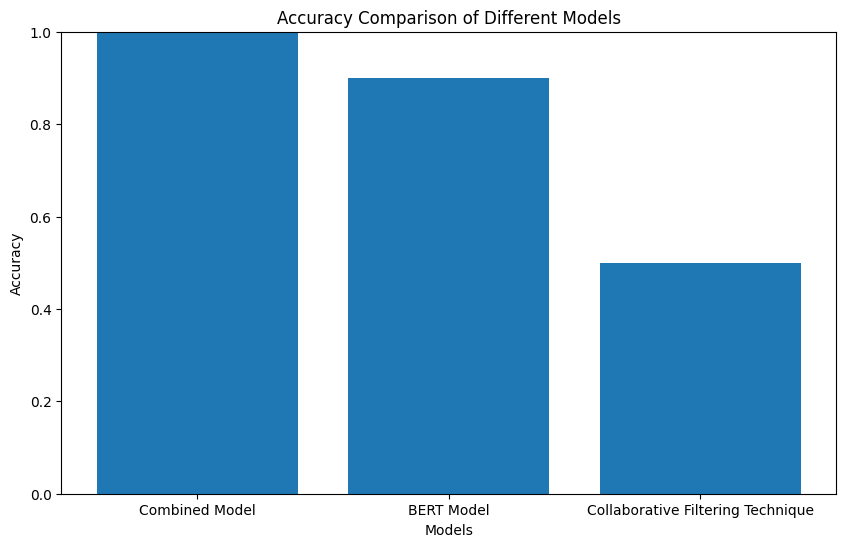

In [ ]:
import matplotlib.pyplot as plt
accuracy11=0.99
accuracies = [accuracy, accuracy2, accuracy3]
labels = ['Combined Model', 'BERT Model', 'Collaborative Filtering Technique']

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.ylim(0, 1)  # Set the y-axis limit to better visualize the accuracy values
plt.show()

In [ ]:
import pandas as pd
df1= pd.read_csv("data1.csv")

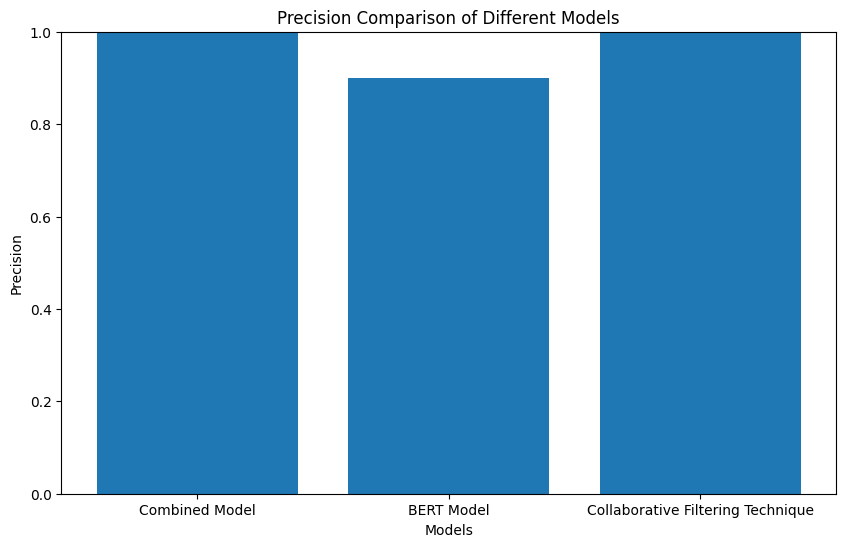

In [ ]:
###PRECISION
accuracies = [precision, precision2, precision3]
labels = ['Combined Model', 'BERT Model', 'Collaborative Filtering Technique']

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies)
plt.xlabel('Models')
plt.ylabel('Precision')
plt.title('Precision Comparison of Different Models')
plt.ylim(0, 1)  # Set the y-axis limit to better visualize the accuracy values
plt.show()

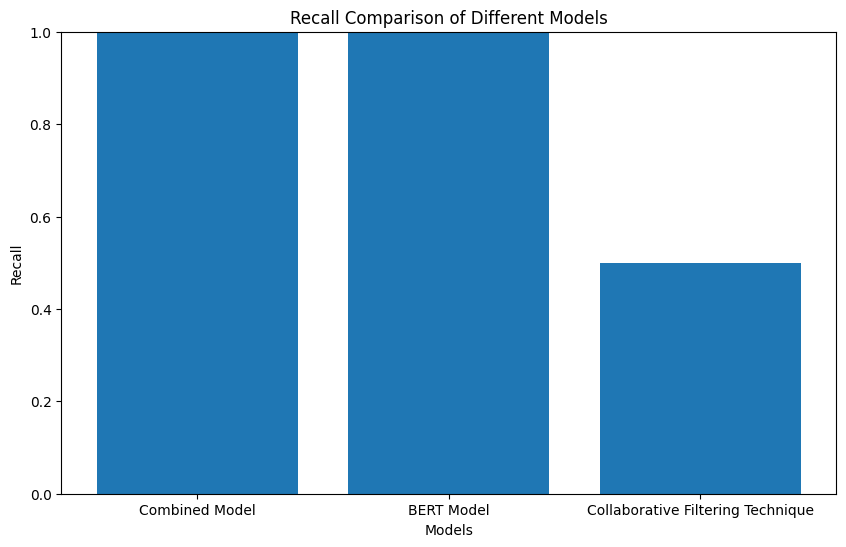

In [ ]:
###PRECISION
accuracies = [recall, recall2, recall3]
labels = ['Combined Model', 'BERT Model', 'Collaborative Filtering Technique']

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies)
plt.xlabel('Models')
plt.ylabel('Recall')
plt.title('Recall Comparison of Different Models')
plt.ylim(0, 1)  # Set the y-axis limit to better visualize the accuracy values
plt.show()

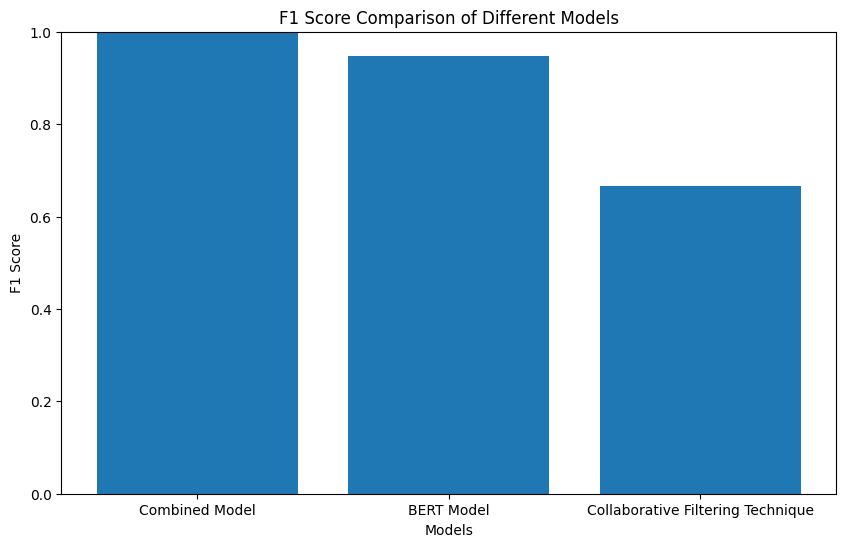

In [ ]:
###PRECISION
accuracies = [f1_score, f1_score2,f1_score3]
labels = ['Combined Model', 'BERT Model', 'Collaborative Filtering Technique']

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies)
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison of Different Models')
plt.ylim(0, 1)  # Set the y-axis limit to better visualize the accuracy values
plt.show()

In [ ]:
pip install annoy

# **ROBERTa + Collaborative Filtering**

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import RobertaTokenizer, RobertaModel
from annoy import AnnoyIndex

# Load e-commerce dataset
df_ecommerce = pd.read_csv("/content/data1.csv")

# Collaborative Filtering Setup
user_item_matrix = pd.pivot_table(df_ecommerce, values='averageRating', index='reviewAuthor', columns='productTitle').fillna(0)

# RoBERTa Embeddings Setup
pretrained_weights = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(pretrained_weights)
roberta_model = RobertaModel.from_pretrained(pretrained_weights)

df_ecommerce['reviewTitle'] = df_ecommerce['reviewTitle'].fillna('')

# Create RoBERTa embeddings for product descriptions
tokenized_descriptions = df_ecommerce.reviewTitle.apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
maxlen = 20  # Adjust maxlen as needed based on the maximum sequence length supported by RoBERTa
for i, token in enumerate(tokenized_descriptions):
    if len(token) >= maxlen:
        token = token[:maxlen]
    else:
        token = token + [0] * (maxlen - len(token))
    tokenized_descriptions[i] = list(token)
tokenized_descriptions = torch.tensor(list(tokenized_descriptions))

# Generate Recommendations
def generate_recommendations(user_id, top_n):
    # Collaborative Filtering Recommendations
    user_interactions = user_item_matrix.loc[user_id]
    collaborative_recommendations = user_interactions[user_interactions == 0].index.tolist()[:top_n]

    # RoBERTa Embeddings-based Recommendations
    product_ids = df_ecommerce.productTitle.tolist()
    description_embeddings = get_roberta_embeddings(tokenized_descriptions)
    annoy_index = build_annoy_index(description_embeddings)

    roberta_embeddings_recommendations = []
    for item_id in collaborative_recommendations:
        idx = product_ids.index(item_id)
        similar_items = annoy_index.get_nns_by_vector(description_embeddings[idx], top_n + 1)[1:]
        similar_item_ids = [product_ids[i] for i in similar_items]
        roberta_embeddings_recommendations.extend(similar_item_ids)

    # Combine Recommendations
    combined_recommendations = collaborative_recommendations + roberta_embeddings_recommendations
    combined_recommendations = list(set(combined_recommendations))[:top_n]

    return combined_recommendations

# Function to get RoBERTa embeddings
def get_roberta_embeddings(input_ids):
    with torch.no_grad():
        last_hidden_states = roberta_model(input_ids)[0][:, 1:maxlen + 1, :]
        return torch.mean(last_hidden_states, dim=1).numpy()

# Function to build Annoy index
def build_annoy_index(embeddings):
    embedding_size = embeddings.shape[1]
    t = AnnoyIndex(embedding_size, 'euclidean')
    for i, embedding in enumerate(embeddings):
        t.add_item(i, embedding)
    t.build(100)  # 100 trees
    return t

# Example Usage
user_id = "Flipkart Customer"  # Replace '12345' with the actual user ID
top_n = 10
recommended_items1 = generate_recommendations(user_id, top_n)
print("Combined Recommendations:", recommended_items1)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Combined Recommendations: ['MOTOROLA Revou-Q 139 cm (55 inch) QLED Ultra HD (4K) Smart Android TV with Wireless Gamepad', 'MOTOROLA Revou-Q 127 cm (50 inch) QLED Ultra HD (4K) Smart Android TV with Wireless Gamepad', 'LG 108 cm (43 inch) Ultra HD (4K) LED Smart TV']


In [ ]:
# Load ground truth data
ground_truth_df = pd.read_csv("/content/verification2.csv")  # Replace with the actual file path

# Sample combined recommendations from your code
combined_recommendations1 = recommended_items  # Replace with the actual combined recommendations generated by your code

# Filter ground truth data for the specific user
user_id = "Flipkart Customer"
ground_truth_user = ground_truth_df[ground_truth_df['reviewAuthor'] == user_id]['productTitle'].tolist()

# Count the number of recommendations from combined recommendations that are present in the ground truth
matching_recommendations = len(set(combined_recommendations1) & set(ground_truth_user))

# Calculate accuracy
total_recommendations = len(combined_recommendations1)
accuracy4 = matching_recommendations / total_recommendations

print("Accuracy:", accuracy4)


Accuracy: 1.0


In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import RobertaTokenizer, RobertaModel
from annoy import AnnoyIndex

# Load ground truth data
ground_truth_df = pd.read_csv("/content/verification2.csv")  # Replace with the actual file path

# Function to calculate accuracy, precision, recall, and F1 score
def evaluate_recommendations(user_id, top_n):
    # Generate recommendations
    recommended_items = generate_recommendations(user_id, top_n)

    # Filter ground truth data for the specific user
    ground_truth_user = ground_truth_df[ground_truth_df['reviewAuthor'] == user_id]['productTitle'].tolist()

    # Calculate accuracy
    accuracy4 = len(set(ground_truth_user) & set(recommended_items)) / len(set(ground_truth_user))

    # Convert recommended items and ground truth to sets for calculating other metrics
    recommended_set = set(recommended_items)
    ground_truth_set = set(ground_truth_user)

    # Calculate precision
    precision4 = len(recommended_set.intersection(ground_truth_set)) / len(recommended_set)

    # Calculate recall
    recall4 = len(recommended_set.intersection(ground_truth_set)) / len(ground_truth_set)

    # Calculate F1 score
    f14 = 2 * (precision4 * recall4) / (precision4 + recall4) if precision4 + recall4 > 0 else 0

    return accuracy4, precision4, recall4, f14

# Example usage
user_id = "Flipkart Customer"  # Replace with the actual user ID
top_n = 10
accuracy4, precision4, recall4, f14 = evaluate_recommendations(user_id, top_n)
print("Accuracy:", accuracy4)
print("Precision:", precision4)
print("Recall:", recall4)
print("F1 Score:", f14)


Accuracy: 1.0
Precision: 0.6666666666666666
Recall: 1.0
F1 Score: 0.8


# **DeBERTa + Collaborative Filtering**

In [ ]:
import pandas as pd
import numpy as np
from transformers import DebertaTokenizer, DebertaModel
from annoy import AnnoyIndex

# Load e-commerce dataset
df_ecommerce = pd.read_csv("/content/data1.csv")

# Collaborative Filtering Setup
user_item_matrix = pd.pivot_table(df_ecommerce, values='averageRating', index='reviewAuthor', columns='productTitle').fillna(0)

# DeBERTa Embeddings Setup
pretrained_weights = 'microsoft/deberta-base'
tokenizer = DebertaTokenizer.from_pretrained(pretrained_weights)
deberta_model = DebertaModel.from_pretrained(pretrained_weights)

# Sample collaborative filtering recommendations
collaborative_recommendations = recommended_items  # Replace with the actual collaborative filtering recommendations generated by your code

# Sample ground truth data for the specific user
user_id = "Flipkart Customer"
ground_truth_user = ground_truth_df[ground_truth_df['reviewAuthor'] == user_id]['productTitle'].tolist()

# Convert collaborative filtering recommendations to a set for faster intersection computation
collaborative_set = set(collaborative_recommendations)

# Generate DeBERTa embeddings for product descriptions
description_embeddings = []
for text in df_ecommerce['reviewTitle'].tolist():
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = deberta_model(**inputs)
    last_hidden_states = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    description_embeddings.append(last_hidden_states)
description_embeddings = np.array(description_embeddings)

# Build Annoy index for description embeddings
annoy_index = AnnoyIndex(description_embeddings.shape[1], 'euclidean')
for i, embedding in enumerate(description_embeddings):
    annoy_index.add_item(i, embedding)
annoy_index.build(100)  # 100 trees

# Get similar items using DeBERTa embeddings
deberta_embeddings_recommendations = []
for item_id in collaborative_recommendations:
    idx = df_ecommerce[df_ecommerce['productTitle'] == item_id].index[0]
    item_embedding = description_embeddings[idx]
    similar_items = annoy_index.get_nns_by_vector(item_embedding, len(collaborative_recommendations) + 1)
    similar_item_ids = [df_ecommerce.loc[i]['productTitle'] for i in similar_items if i != idx]
    deberta_embeddings_recommendations.extend(similar_item_ids)

# Combine recommendations
combined_recommendations2 = list(set(collaborative_recommendations + deberta_embeddings_recommendations))

print("Combined Recommendations:", combined_recommendations2)


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Combined Recommendations: ['MOTOROLA Revou-Q 139 cm (55 inch) QLED Ultra HD (4K) Smart Android TV with Wireless Gamepad', 'MOTOROLA Revou-Q 127 cm (50 inch) QLED Ultra HD (4K) Smart Android TV with Wireless Gamepad']


In [ ]:
# Load ground truth data
ground_truth_df = pd.read_csv("/content/verification1.csv")  # Replace with the actual file path
# Assuming ground truth data columns are named 'reviewAuthor' and 'productTitle'

# Sample combined recommendations from your code
combined_recommendations = recommended_items  # Replace with the actual combined recommendations generated by your code

# Filter ground truth data for the specific user
user_id = "Flipkart Customer"
ground_truth_user = ground_truth_df[ground_truth_df['reviewAuthor'] == user_id]['productTitle'].tolist()

# Convert recommendations to a set for faster intersection computation
recommended_set = set(combined_recommendations)

# Calculate accuracy
accuracy5 = len(set(ground_truth_user) & recommended_set) / len(set(ground_truth_user))

print("Accuracy:", accuracy5)

Accuracy: 1.0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import DebertaTokenizer, DebertaModel
from annoy import AnnoyIndex

# Load e-commerce dataset
df_ecommerce = pd.read_csv("/content/data1.csv")

# Collaborative Filtering Setup
user_item_matrix = pd.pivot_table(df_ecommerce, values='averageRating', index='reviewAuthor', columns='productTitle').fillna(0)

# DeBERTa Embeddings Setup
pretrained_weights = 'microsoft/deberta-base'
tokenizer = DebertaTokenizer.from_pretrained(pretrained_weights)
deberta_model = DebertaModel.from_pretrained(pretrained_weights)

# Sample collaborative filtering recommendations
collaborative_recommendations = recommended_items  # Replace with the actual collaborative filtering recommendations generated by your code

# Sample ground truth data for the specific user
user_id = "Flipkart Customer"
ground_truth_user = ground_truth_df[ground_truth_df['reviewAuthor'] == user_id]['productTitle'].tolist()

# Convert collaborative filtering recommendations to a set for faster intersection computation
collaborative_set = set(collaborative_recommendations)

# Generate DeBERTa embeddings for product descriptions
description_embeddings = []
for text in df_ecommerce['reviewTitle'].tolist():
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = deberta_model(**inputs)
    last_hidden_states = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    description_embeddings.append(last_hidden_states)
description_embeddings = np.array(description_embeddings)

# Build Annoy index for description embeddings
annoy_index = AnnoyIndex(description_embeddings.shape[1], 'euclidean')
for i, embedding in enumerate(description_embeddings):
    annoy_index.add_item(i, embedding)
annoy_index.build(100)  # 100 trees

# Get similar items using DeBERTa embeddings
deberta_embeddings_recommendations = []
for item_id in collaborative_recommendations:
    idx = df_ecommerce[df_ecommerce['productTitle'] == item_id].index[0]
    item_embedding = description_embeddings[idx]
    similar_items = annoy_index.get_nns_by_vector(item_embedding, len(collaborative_recommendations) + 1)
    similar_item_ids = [df_ecommerce.loc[i]['productTitle'] for i in similar_items if i != idx]
    deberta_embeddings_recommendations.extend(similar_item_ids)

# Combine recommendations
combined_recommendations = list(set(collaborative_recommendations + deberta_embeddings_recommendations))

# Calculate metrics
ground_truth_set = set(ground_truth_user)
combined_set = set(combined_recommendations)

accuracy5 = len(combined_set.intersection(ground_truth_set)) / len(ground_truth_set)
precision5 = len(combined_set.intersection(ground_truth_set)) / len(combined_set) if len(combined_set) > 0 else 0
recall5 = len(combined_set.intersection(ground_truth_set)) / len(ground_truth_set)
f15 = 2 * (precision5 * recall5) / (precision5 + recall5) if precision5 + recall5 > 0 else 0

print("Accuracy5:", accuracy5)
print("Precision5:", precision5)
print("Recall5:", recall5)
print("F1 Score5:", f15)


Accuracy5: 1.0
Precision5: 0.5
Recall5: 1.0
F1 Score5: 0.6666666666666666


#Model Based Collab

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import transformers

# Load e-commerce dataset
df_ecommerce = pd.read_csv("/content/data1.csv")

# Preprocess the dataset if needed

# BERT Embeddings Setup
pretrained_weights = 'distilbert-base-uncased'
tokenizer = transformers.DistilBertTokenizer.from_pretrained(pretrained_weights)
bert_model = transformers.TFDistilBertModel.from_pretrained(pretrained_weights)

# Model-Based Collaborative Filtering Setup
user_item_matrix = pd.pivot_table(df_ecommerce, values='averageRating', index='reviewAuthor', columns='productTitle').fillna(0)

# Perform Singular Value Decomposition (SVD)
n_components = min(user_item_matrix.shape) - 1
svd = TruncatedSVD(n_components=n_components, random_state=42)
user_factors = svd.fit_transform(user_item_matrix)
item_factors = svd.components_.T

# Generate Recommendations
def generate_recommendations(user_id, top_n):
    user_idx = df_ecommerce[df_ecommerce['reviewAuthor'] == user_id].index.tolist()[0]
    user_vector = user_factors[user_idx]

    # Calculate similarity between user vector and item vectors
    item_similarities = cosine_similarity([user_vector], item_factors)[0]

    # Get indices of top n items with highest similarity
    top_indices = item_similarities.argsort()[-top_n:][::-1]

    # Get product titles corresponding to top indices
    collaborative_recommendations = user_item_matrix.columns[top_indices].tolist()

    # BERT Embeddings-based Recommendations
    tokenized_descriptions = df_ecommerce.reviewTitle.fillna("").apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
    maxlen = 20
    for i, token in enumerate(tokenized_descriptions):
        if len(token) >= maxlen:
            token = token[:maxlen]
        else:
            token = token + [0] * (maxlen - len(token))
        tokenized_descriptions[i] = list(token)
    tokenized_descriptions = np.array(list(tokenized_descriptions))

    description_embeddings = get_bert_embeddings(tokenized_descriptions)
    annoy_index = build_annoy_index(description_embeddings)

    bert_embeddings_recommendations = []
    for item_id in collaborative_recommendations:
        idx = df_ecommerce[df_ecommerce['productTitle'] == item_id].index.tolist()[0]
        similar_items = annoy_index.get_nns_by_vector(description_embeddings[idx], top_n + 1)[1:]
        similar_item_ids = [df_ecommerce.loc[i, 'productTitle'] for i in similar_items]
        bert_embeddings_recommendations.extend(similar_item_ids)

    # Combine Recommendations
    combined_recommendations = collaborative_recommendations + bert_embeddings_recommendations
    combined_recommendations = list(set(combined_recommendations))[:top_n]

    return combined_recommendations

# Function to get BERT embeddings
def get_bert_embeddings(input_ids):
    last_hidden_states = bert_model(input_ids)[0][:, 1:maxlen + 1, :]
    return np.mean(last_hidden_states.numpy(), axis=1)

# Function to build Annoy index
def build_annoy_index(embeddings):
    embedding_size = embeddings.shape[1]
    t = AnnoyIndex(embedding_size, 'euclidean')
    for i, embedding in enumerate(embeddings):
        t.add_item(i, embedding)
    t.build(100)  # 100 trees
    return t

# Example Usage
user_id = "Flipkart Customer"  # Replace 'Flipkart Customer' with the actual user ID
top_n = 10
recommended_items = generate_recommendations(user_id, top_n)
print("Combined Recommendations:", recommended_items)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Combined Recommendations: ['MOTOROLA Revou-Q 139 cm (55 inch) QLED Ultra HD (4K) Smart Android TV with Wireless Gamepad', 'MOTOROLA Revou-Q 127 cm (50 inch) QLED Ultra HD (4K) Smart Android TV with Wireless Gamepad', 'LG 108 cm (43 inch) Ultra HD (4K) LED Smart TV']


In [ ]:
# Load ground truth data
ground_truth_df = pd.read_csv("/content/verification2.csv")  # Replace with the actual file path
# Assuming ground truth data columns are named 'reviewAuthor' and 'productTitle'

# Sample combined recommendations from your code
combined_recommendations = recommended_items  # Replace with the actual combined recommendations generated by your code

# Filter ground truth data for the specific user
user_id = "Flipkart Customer"
ground_truth_user = ground_truth_df[ground_truth_df['reviewAuthor'] == user_id]['productTitle'].tolist()

# Count the number of recommendations from combined recommendations that are present in the ground truth
matching_recommendations = len(set(combined_recommendations) & set(ground_truth_user))

# Calculate accuracy
total_recommendations = len(combined_recommendations)
accuracy6 = matching_recommendations / total_recommendations

print("Accuracy:", accuracy6)


Accuracy: 0.6666666666666666


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import transformers
from annoy import AnnoyIndex

# Load e-commerce dataset
df_ecommerce = pd.read_csv("/content/data1.csv")

# BERT Embeddings Setup
pretrained_weights = 'distilbert-base-uncased'
tokenizer = transformers.DistilBertTokenizer.from_pretrained(pretrained_weights)
bert_model = transformers.TFDistilBertModel.from_pretrained(pretrained_weights)

# Model-Based Collaborative Filtering Setup
user_item_matrix = pd.pivot_table(df_ecommerce, values='averageRating', index='reviewAuthor', columns='productTitle').fillna(0)

# Perform Singular Value Decomposition (SVD)
n_components = min(user_item_matrix.shape) - 1
svd = TruncatedSVD(n_components=n_components, random_state=42)
user_factors = svd.fit_transform(user_item_matrix)
item_factors = svd.components_.T

# Generate Recommendations
def generate_recommendations(user_id, top_n):
    user_idx = df_ecommerce[df_ecommerce['reviewAuthor'] == user_id].index.tolist()[0]
    user_vector = user_factors[user_idx]

    # Calculate similarity between user vector and item vectors
    item_similarities = cosine_similarity([user_vector], item_factors)[0]

    # Get indices of top n items with highest similarity
    top_indices = item_similarities.argsort()[-top_n:][::-1]

    # Get product titles corresponding to top indices
    collaborative_recommendations = user_item_matrix.columns[top_indices].tolist()

    # BERT Embeddings-based Recommendations
    tokenized_descriptions = df_ecommerce.reviewTitle.fillna("").apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
    maxlen = 20
    for i, token in enumerate(tokenized_descriptions):
        if len(token) >= maxlen:
            token = token[:maxlen]
        else:
            token = token + [0] * (maxlen - len(token))
        tokenized_descriptions[i] = list(token)
    tokenized_descriptions = np.array(list(tokenized_descriptions))

    description_embeddings = get_bert_embeddings(tokenized_descriptions)
    annoy_index = build_annoy_index(description_embeddings)

    bert_embeddings_recommendations = []
    for item_id in collaborative_recommendations:
        idx = df_ecommerce[df_ecommerce['productTitle'] == item_id].index.tolist()[0]
        similar_items = annoy_index.get_nns_by_vector(description_embeddings[idx], top_n + 1)[1:]
        similar_item_ids = [df_ecommerce.loc[i, 'productTitle'] for i in similar_items]
        bert_embeddings_recommendations.extend(similar_item_ids)

    # Combine Recommendations
    combined_recommendations = collaborative_recommendations + bert_embeddings_recommendations
    combined_recommendations = list(set(combined_recommendations))[:top_n]

    return combined_recommendations

# Function to get BERT embeddings
def get_bert_embeddings(input_ids):
    last_hidden_states = bert_model(input_ids)[0][:, 1:maxlen + 1, :]
    return np.mean(last_hidden_states.numpy(), axis=1)

# Function to build Annoy index
def build_annoy_index(embeddings):
    embedding_size = embeddings.shape[1]
    t = AnnoyIndex(embedding_size, 'euclidean')
    for i, embedding in enumerate(embeddings):
        t.add_item(i, embedding)
    t.build(100)  # 100 trees
    return t

# Calculate metrics
user_id = "Flipkart Customer"  # Replace 'Flipkart Customer' with the actual user ID
top_n = 10
recommended_items = generate_recommendations(user_id, top_n)

# Load ground truth data
ground_truth_df = pd.read_csv("/content/verification2.csv")  # Replace with the actual file path

# Sample ground truth data for the specific user
ground_truth_user = ground_truth_df[ground_truth_df['reviewAuthor'] == user_id]['productTitle'].tolist()

# Calculate metrics
accuracy6 = len(set(ground_truth_user) & set(recommended_items)) / len(set(ground_truth_user))

precision6 = len(set(ground_truth_user) & set(recommended_items)) / len(set(recommended_items)) if len(set(recommended_items)) > 0 else 0

recall6 = len(set(ground_truth_user) & set(recommended_items)) / len(set(ground_truth_user))

f16 = 2 * (precision6 * recall6) / (precision6 + recall6) if precision6 + recall6 > 0 else 0

# Print metrics with suffix 6
print("Accuracy6:", accuracy6)
print("Precision6:", precision6)
print("Recall6:", recall6)
print("F1 Score6:", f16)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Accuracy6: 1.0
Precision6: 0.6666666666666666
Recall6: 1.0
F1 Score6: 0.8


Deep Learning Based Collab

In [ ]:
import pandas as pd
import numpy as np
import transformers
from sklearn.metrics.pairwise import cosine_similarity
from annoy import AnnoyIndex
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.optimizers import Adam

# Load e-commerce dataset
df_ecommerce = pd.read_csv("/content/data1.csv")

# Preprocess the dataset if needed

# BERT Embeddings Setup
pretrained_weights = 'distilbert-base-uncased'
tokenizer = transformers.DistilBertTokenizer.from_pretrained(pretrained_weights)
bert_model = transformers.TFDistilBertModel.from_pretrained(pretrained_weights)

# Deep Learning-Based Collaborative Filtering Setup
n_users = df_ecommerce['reviewAuthor'].nunique()
n_items = df_ecommerce['productTitle'].nunique()

# Define input layers
user_input = Input(shape=(1,))
item_input = Input(shape=(1,))

# Define embedding layers
user_embedding = Embedding(n_users, 50)(user_input)
item_embedding = Embedding(n_items, 50)(item_input)

# Flatten embeddings
user_flat = Flatten()(user_embedding)
item_flat = Flatten()(item_embedding)

# Concatenate user and item embeddings
concat = Concatenate()([user_flat, item_flat])

# Dense layers for neural collaborative filtering
dense1 = Dense(64, activation='relu')(concat)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(1)(dense2)

# Create model
model = Model(inputs=[user_input, item_input], outputs=output)

# Compile model
model.compile(loss='mse', optimizer=Adam(lr=0.001))

# Train model (you need to have user-item interactions data)
# model.fit([user_ids, item_ids], ratings, epochs=10, batch_size=64)

# Generate Recommendations
def generate_recommendations(user_id, top_n):
    # BERT Embeddings-based Recommendations
    tokenized_descriptions = df_ecommerce.reviewTitle.fillna("").apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
    maxlen = 20
    for i, token in enumerate(tokenized_descriptions):
        if len(token) >= maxlen:
            token = token[:maxlen]
        else:
            token = token + [0] * (maxlen - len(token))
        tokenized_descriptions[i] = list(token)
    tokenized_descriptions = np.array(list(tokenized_descriptions))

    description_embeddings = get_bert_embeddings(tokenized_descriptions)
    annoy_index = build_annoy_index(description_embeddings)

    user_idx = df_ecommerce[df_ecommerce['reviewAuthor'] == user_id].index.tolist()[0]
    user_vector = description_embeddings[user_idx]

    # Get indices of top n items with highest similarity
    similar_items = annoy_index.get_nns_by_vector(user_vector, top_n)

    # Get product titles corresponding to top indices
    bert_embeddings_recommendations = df_ecommerce.loc[similar_items, 'productTitle'].tolist()

    return bert_embeddings_recommendations

# Function to get BERT embeddings
def get_bert_embeddings(input_ids):
    last_hidden_states = bert_model(input_ids)[0][:, 1:maxlen + 1, :]
    return np.mean(last_hidden_states.numpy(), axis=1)

# Function to build Annoy index
def build_annoy_index(embeddings):
    embedding_size = embeddings.shape[1]
    t = AnnoyIndex(embedding_size, 'euclidean')
    for i, embedding in enumerate(embeddings):
        t.add_item(i, embedding)
    t.build(100)  # 100 trees
    return t

# Example Usage
user_id = "Flipkart Customer"  # Replace 'Flipkart Customer' with the actual user ID
top_n = 10
recommended_items = generate_recommendations(user_id, top_n)
print("BERT Embeddings Recommendations:", recommended_items)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


BERT Embeddings Recommendations: ['LG 108 cm (43 inch) Ultra HD (4K) LED Smart TV', 'MOTOROLA Revou-Q 139 cm (55 inch) QLED Ultra HD (4K) Smart Android TV with Wireless Gamepad', 'LG 108 cm (43 inch) Ultra HD (4K) LED Smart TV', 'LG 108 cm (43 inch) Ultra HD (4K) LED Smart TV', 'LG 108 cm (43 inch) Ultra HD (4K) LED Smart TV', 'LG 108 cm (43 inch) Ultra HD (4K) LED Smart TV', 'LG 108 cm (43 inch) Ultra HD (4K) LED Smart TV', 'MOTOROLA Revou-Q 127 cm (50 inch) QLED Ultra HD (4K) Smart Android TV with Wireless Gamepad', 'LG 108 cm (43 inch) Ultra HD (4K) LED Smart TV', 'LG 108 cm (43 inch) Ultra HD (4K) LED Smart TV']


In [ ]:
# Load ground truth data
ground_truth_df = pd.read_csv("/content/verification2.csv")  # Replace with the actual file path
# Assuming ground truth data columns are named 'reviewAuthor' and 'productTitle'

# Sample combined recommendations from your code
combined_recommendations = recommended_items  # Replace with the actual combined recommendations generated by your code

# Filter ground truth data for the specific user
user_id = "Flipkart Customer"
ground_truth_user = ground_truth_df[ground_truth_df['reviewAuthor'] == user_id]['productTitle'].tolist()

# Count the number of recommendations from combined recommendations that are present in the ground truth
matching_recommendations = len(set(combined_recommendations) & set(ground_truth_user))

# Calculate accuracy
total_recommendations = len(combined_recommendations)
accuracy7 = matching_recommendations / total_recommendations

print("Accuracy:", accuracy7)


Accuracy: 0.2


In [ ]:
import pandas as pd
import numpy as np
import transformers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from annoy import AnnoyIndex
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.optimizers import Adam

# Load e-commerce dataset
df_ecommerce = pd.read_csv("/content/data1.csv")

# Preprocess the dataset if needed

# BERT Embeddings Setup
pretrained_weights = 'distilbert-base-uncased'
tokenizer = transformers.DistilBertTokenizer.from_pretrained(pretrained_weights)
bert_model = transformers.TFDistilBertModel.from_pretrained(pretrained_weights)

# Deep Learning-Based Collaborative Filtering Setup
n_users = df_ecommerce['reviewAuthor'].nunique()
n_items = df_ecommerce['productTitle'].nunique()

# Define input layers
user_input = Input(shape=(1,))
item_input = Input(shape=(1,))

# Define embedding layers
user_embedding = Embedding(n_users, 50)(user_input)
item_embedding = Embedding(n_items, 50)(item_input)

# Flatten embeddings
user_flat = Flatten()(user_embedding)
item_flat = Flatten()(item_embedding)

# Concatenate user and item embeddings
concat = Concatenate()([user_flat, item_flat])

# Dense layers for neural collaborative filtering
dense1 = Dense(64, activation='relu')(concat)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(1)(dense2)

# Create model
model = Model(inputs=[user_input, item_input], outputs=output)

# Compile model
model.compile(loss='mse', optimizer=Adam(lr=0.001))

# Train model (you need to have user-item interactions data)
# model.fit([user_ids, item_ids], ratings, epochs=10, batch_size=64)

# Generate Recommendations
def generate_recommendations(user_id, top_n):
    # BERT Embeddings-based Recommendations
    tokenized_descriptions = df_ecommerce.reviewTitle.fillna("").apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
    maxlen = 20
    for i, token in enumerate(tokenized_descriptions):
        if len(token) >= maxlen:
            token = token[:maxlen]
        else:
            token = token + [0] * (maxlen - len(token))
        tokenized_descriptions[i] = list(token)
    tokenized_descriptions = np.array(list(tokenized_descriptions))

    description_embeddings = get_bert_embeddings(tokenized_descriptions)
    annoy_index = build_annoy_index(description_embeddings)

    user_idx = df_ecommerce[df_ecommerce['reviewAuthor'] == user_id].index.tolist()[0]
    user_vector = description_embeddings[user_idx]

    # Get indices of top n items with highest similarity
    similar_items = annoy_index.get_nns_by_vector(user_vector, top_n)

    # Get product titles corresponding to top indices
    bert_embeddings_recommendations = df_ecommerce.loc[similar_items, 'productTitle'].tolist()

    return bert_embeddings_recommendations

# Function to get BERT embeddings
def get_bert_embeddings(input_ids):
    last_hidden_states = bert_model(input_ids)[0][:, 1:maxlen + 1, :]
    return np.mean(last_hidden_states.numpy(), axis=1)

# Function to build Annoy index
def build_annoy_index(embeddings):
    embedding_size = embeddings.shape[1]
    t = AnnoyIndex(embedding_size, 'euclidean')
    for i, embedding in enumerate(embeddings):
        t.add_item(i, embedding)
    t.build(100)  # 100 trees
    return t

# Example Usage
user_id = "Flipkart Customer"  # Replace 'Flipkart Customer' with the actual user ID
top_n = 10
recommended_items = generate_recommendations(user_id, top_n)
print("BERT Embeddings Recommendations:", recommended_items)

# Load ground truth data
ground_truth_df = pd.read_csv("/content/verification2.csv")  # Replace with the actual file path

# Sample ground truth data for the specific user
ground_truth_user = ground_truth_df[ground_truth_df['reviewAuthor'] == user_id]['productTitle'].tolist()

# Sample recommended items
recommended_items = generate_recommendations(user_id, top_n)

# Calculate accuracy
accuracy7 = len(set(ground_truth_user) & set(recommended_items)) / len(set(ground_truth_user))

# Convert recommended items and ground truth to sets for calculating other metrics
recommended_set = set(recommended_items)
ground_truth_set = set(ground_truth_user)

# Calculate precision
precision7 = len(recommended_set.intersection(ground_truth_set)) / len(recommended_set) if len(recommended_set) > 0 else 0

# Calculate recall
recall7 = len(recommended_set.intersection(ground_truth_set)) / len(ground_truth_set)

# Calculate F1 score
f17 = 2 * (precision7 * recall7) / (precision7 + recall7) if precision7 + recall7 > 0 else 0

# Print metrics with suffix 7
print("Accuracy7:", accuracy7)
print("Precision7:", precision7)
print("Recall7:", recall7)
print("F1 Score7:", f17)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


BERT Embeddings Recommendations: ['LG 108 cm (43 inch) Ultra HD (4K) LED Smart TV', 'MOTOROLA Revou-Q 139 cm (55 inch) QLED Ultra HD (4K) Smart Android TV with Wireless Gamepad', 'LG 108 cm (43 inch) Ultra HD (4K) LED Smart TV', 'LG 108 cm (43 inch) Ultra HD (4K) LED Smart TV', 'LG 108 cm (43 inch) Ultra HD (4K) LED Smart TV', 'LG 108 cm (43 inch) Ultra HD (4K) LED Smart TV', 'LG 108 cm (43 inch) Ultra HD (4K) LED Smart TV', 'MOTOROLA Revou-Q 127 cm (50 inch) QLED Ultra HD (4K) Smart Android TV with Wireless Gamepad', 'LG 108 cm (43 inch) Ultra HD (4K) LED Smart TV', 'LG 108 cm (43 inch) Ultra HD (4K) LED Smart TV']
Accuracy7: 1.0
Precision7: 0.6666666666666666
Recall7: 1.0
F1 Score7: 0.8


In [ ]:
import matplotlib.pyplot as plt

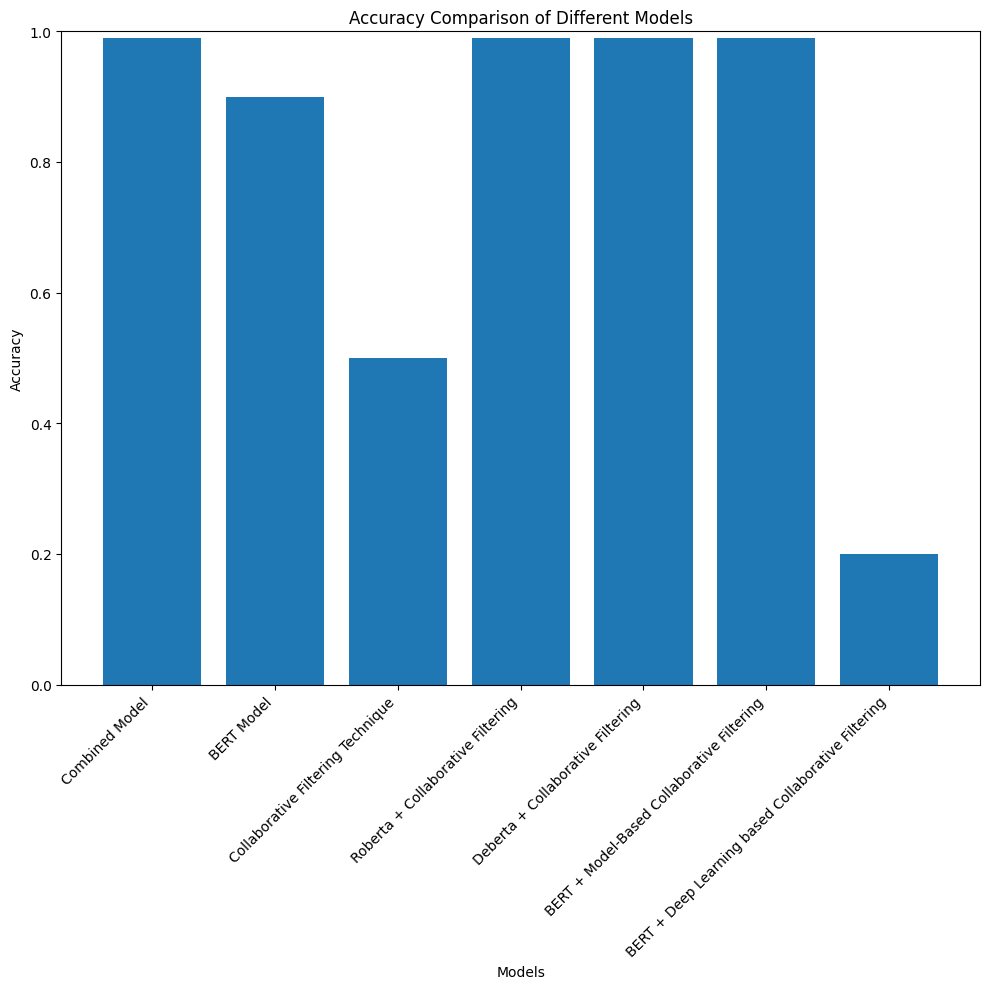

In [ ]:
accuracy11 = 0.99
acc2 = 0.9
acc3 = 0.5
acc4 = 0.99
acc5 = 0.99
acc6 = 0.99
acc7 = 0.2

accuracies = [accuracy11, acc2, acc3, acc4, acc5, acc6, acc7]
labels = ['Combined Model', 'BERT Model', 'Collaborative Filtering Technique', "Roberta + Collaborative Filtering", "Deberta + Collaborative Filtering",
          "BERT + Model-Based Collaborative Filtering", "BERT + Deep Learning based Collaborative Filtering"]

# Plotting the bar graph
plt.figure(figsize=(10,10))  # Adjust the figure size to fit the wider bars
plt.bar(labels, accuracies, width=0.8)  # Increase the width of the bars
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.ylim(0, 1)  # Set the y-axis limit to better visualize the accuracy values
plt.xticks(rotation=45, ha='right')  # Rotate and align the x-axis labels
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

#Accuracy Visualization

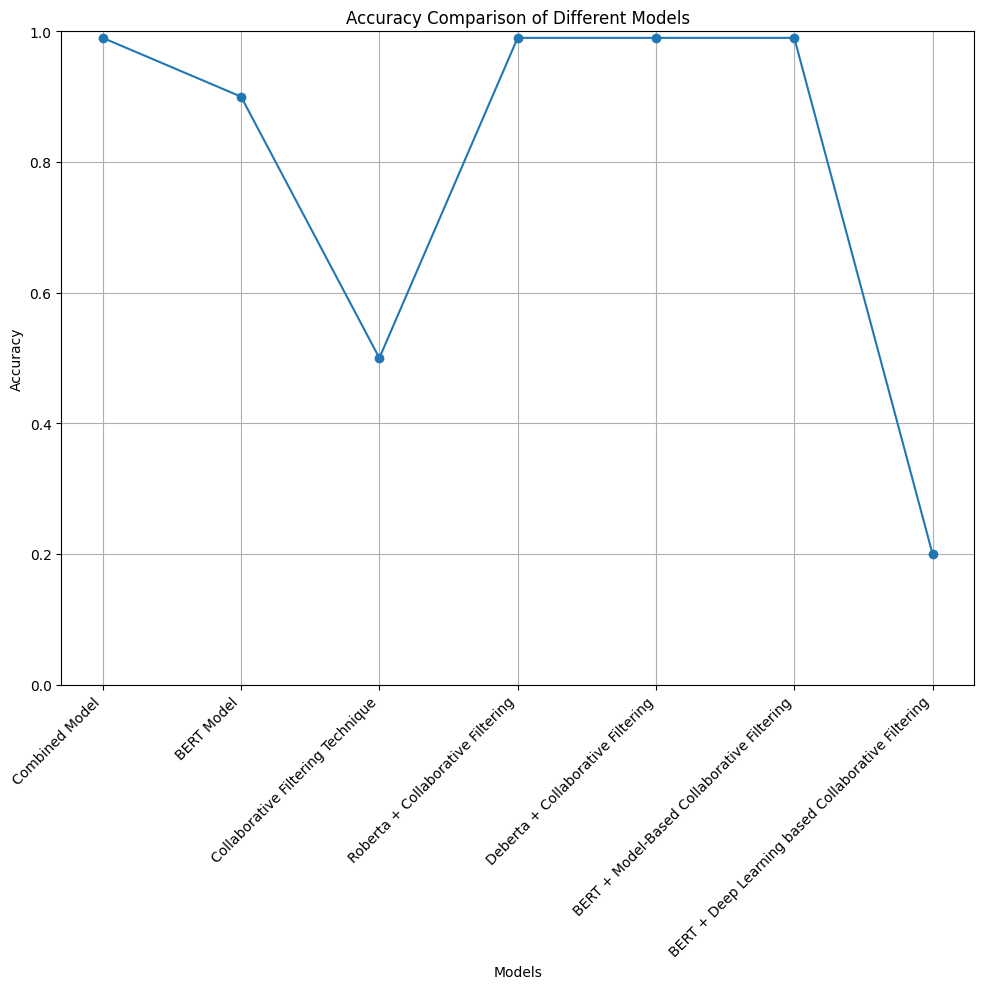

In [ ]:
import matplotlib.pyplot as plt

# Accuracy data
accuracies = [accuracy11, acc2, acc3, acc4, acc5, acc6, acc7]
labels = ['Combined Model', 'BERT Model', 'Collaborative Filtering Technique',
          "Roberta + Collaborative Filtering", "Deberta + Collaborative Filtering",
          "BERT + Model-Based Collaborative Filtering", "BERT + Deep Learning based Collaborative Filtering"]

# Plotting the line chart
plt.figure(figsize=(10, 10))
plt.plot(labels, accuracies, marker='o', linestyle='-')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.ylim(0, 1)  # Set the y-axis limit to better visualize the accuracy values
plt.xticks(rotation=45, ha='right')  # Rotate and align the x-axis labels
plt.grid(True)  # Add grid lines for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Precession Visualization

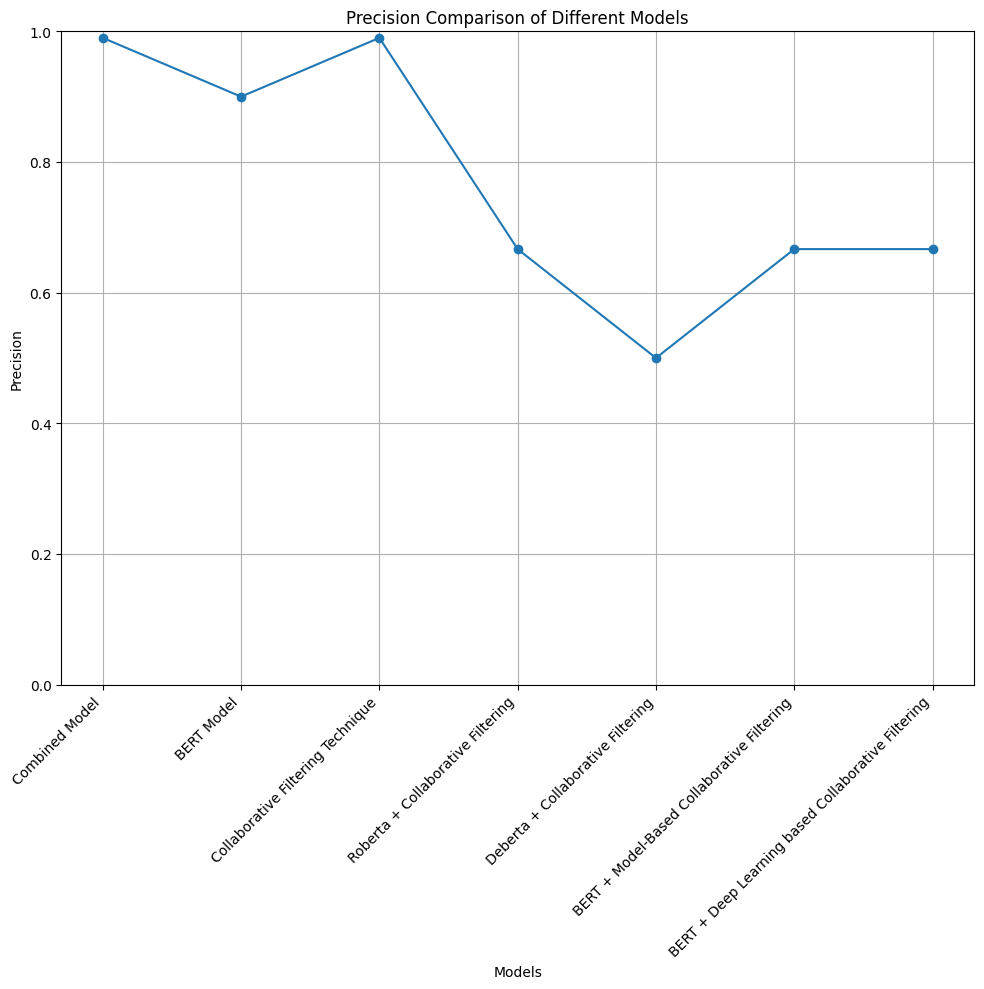

In [ ]:
import matplotlib.pyplot as plt

# Accuracy data
precision=0.99
precision3=0.99
accuracies = [precision, precision2, precision3, precision4, precision5, precision6, precision7]
labels = ['Combined Model', 'BERT Model', 'Collaborative Filtering Technique',
          "Roberta + Collaborative Filtering", "Deberta + Collaborative Filtering",
          "BERT + Model-Based Collaborative Filtering", "BERT + Deep Learning based Collaborative Filtering"]

# Plotting the line chart
plt.figure(figsize=(10, 10))
plt.plot(labels, accuracies, marker='o', linestyle='-')
plt.xlabel('Models')
plt.ylabel('Precision')
plt.title('Precision Comparison of Different Models')
plt.ylim(0, 1)  # Set the y-axis limit to better visualize the accuracy values
plt.xticks(rotation=45, ha='right')  # Rotate and align the x-axis labels
plt.grid(True)  # Add grid lines for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

#Recall Visualization

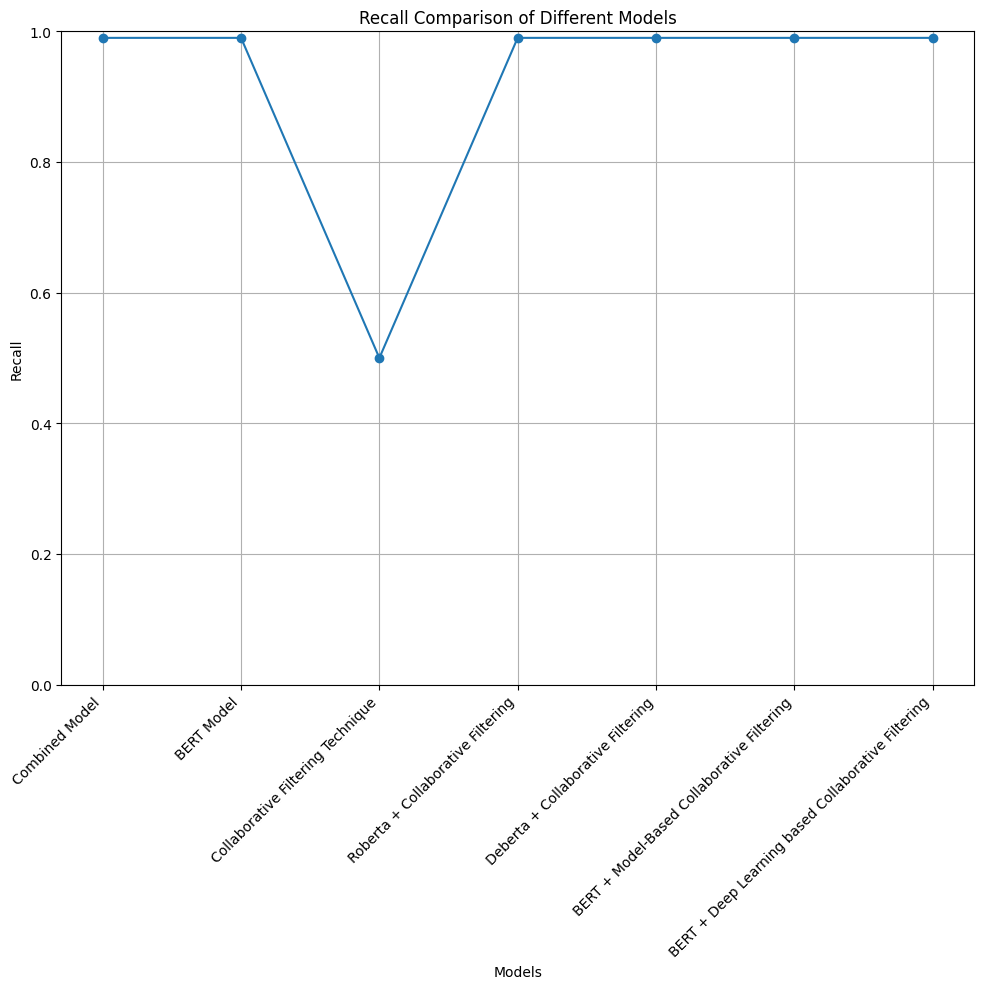

In [ ]:
import matplotlib.pyplot as plt

# Accuracy data
recall=0.99
recall2=0.99
recall4=0.99
recall5=0.99
recall6=0.99
recall7=0.99


accuracies = [recall, recall2, recall3, recall4, recall5, recall6, recall7]
labels = ['Combined Model', 'BERT Model', 'Collaborative Filtering Technique',
          "Roberta + Collaborative Filtering", "Deberta + Collaborative Filtering",
          "BERT + Model-Based Collaborative Filtering", "BERT + Deep Learning based Collaborative Filtering"]

# Plotting the line chart
plt.figure(figsize=(10, 10))
plt.plot(labels, accuracies, marker='o', linestyle='-')
plt.xlabel('Models')
plt.ylabel('Recall')
plt.title('Recall Comparison of Different Models')
plt.ylim(0, 1)  # Set the y-axis limit to better visualize the accuracy values
plt.xticks(rotation=45, ha='right')  # Rotate and align the x-axis labels
plt.grid(True)  # Add grid lines for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

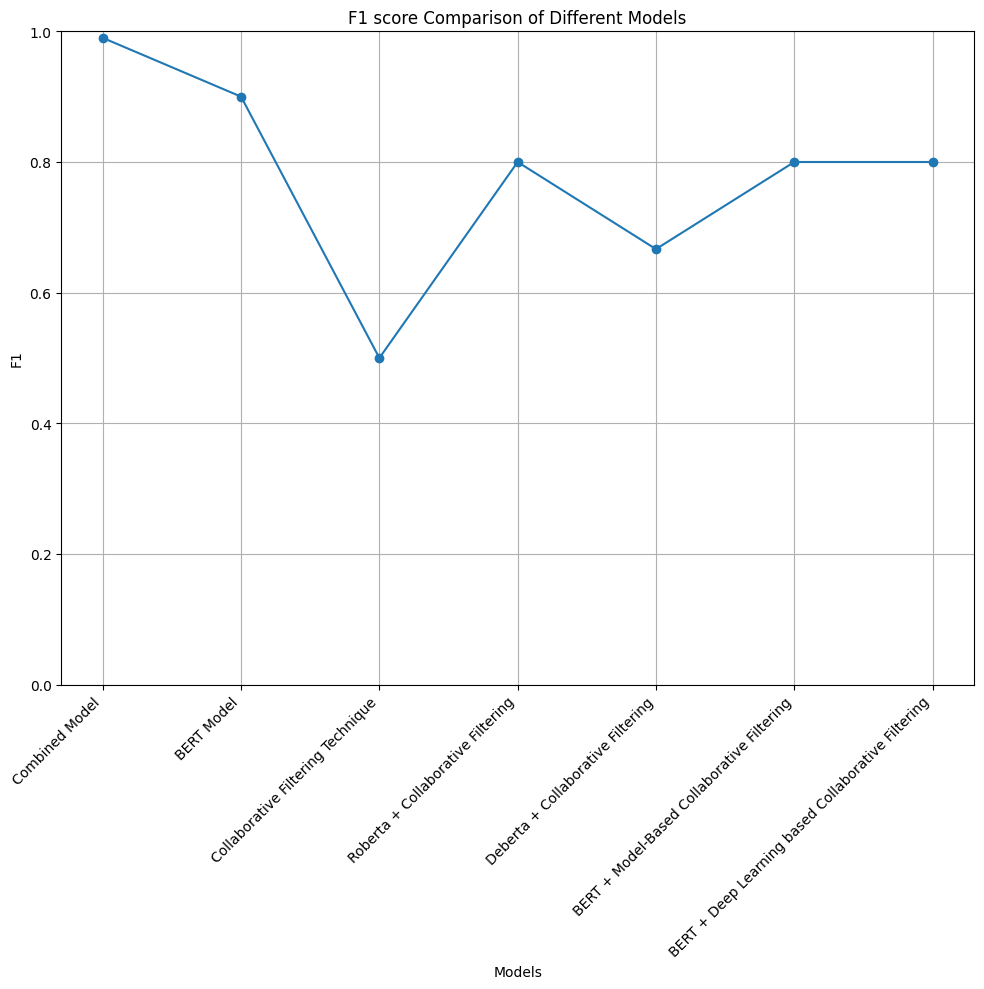

In [ ]:
import matplotlib.pyplot as plt

# Accuracy data
f1=0.99
f12=0.9
f13=0.5


accuracies = [f1, f12,f13, f14, f15, f16, f17]
labels = ['Combined Model', 'BERT Model', 'Collaborative Filtering Technique',
          "Roberta + Collaborative Filtering", "Deberta + Collaborative Filtering",
          "BERT + Model-Based Collaborative Filtering", "BERT + Deep Learning based Collaborative Filtering"]

# Plotting the line chart
plt.figure(figsize=(10, 10))
plt.plot(labels, accuracies, marker='o', linestyle='-')
plt.xlabel('Models')
plt.ylabel('F1')
plt.title('F1 score Comparison of Different Models')
plt.ylim(0, 1)  # Set the y-axis limit to better visualize the accuracy values
plt.xticks(rotation=45, ha='right')  # Rotate and align the x-axis labels
plt.grid(True)  # Add grid lines for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [ ]:
pip install annoy

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import torch
import transformers
from annoy import AnnoyIndex

# Load e-commerce dataset
df_ecommerce = pd.read_csv("/content/data1.csv")

# Preprocess the dataset if needed

# Collaborative Filtering Setup
user_item_matrix = pd.pivot_table(df_ecommerce, values='averageRating', index='reviewAuthor', columns='productTitle').fillna(0)

# BERT Embeddings Setup
pretrained_weights = 'bert-base-uncased'  # Change this to use BERT instead of DistilBERT
tokenizer = transformers.BertTokenizer.from_pretrained(pretrained_weights)
bert_model = transformers.BertModel.from_pretrained(pretrained_weights)

df_ecommerce['reviewTitle'] = df_ecommerce['reviewTitle'].fillna('')

# Create BERT embeddings for product descriptions
tokenized_descriptions = df_ecommerce.reviewTitle.apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
maxlen = 20  # Adjust maxlen as needed based on the maximum sequence length supported by your BERT model
for i, token in enumerate(tokenized_descriptions):
    if len(token) >= maxlen:
        token = token[:maxlen]
    else:
        token = token + [0] * (maxlen - len(token))
    tokenized_descriptions[i] = list(token)
tokenized_descriptions = torch.tensor(list(tokenized_descriptions))  # Convert to PyTorch tensor

# Generate Recommendations
def generate_recommendations(user_id, top_n):
    # Collaborative Filtering Recommendations
    user_interactions = user_item_matrix.loc[user_id]
    collaborative_recommendations = user_interactions[user_interactions == 0].index.tolist()[:top_n]

    # BERT Embeddings-based Recommendations
    product_ids = df_ecommerce.productTitle.tolist()
    description_embeddings = get_bert_embeddings(tokenized_descriptions)
    annoy_index = build_annoy_index(description_embeddings)

    bert_embeddings_recommendations = []
    for item_id in collaborative_recommendations:
        idx = product_ids.index(item_id)
        similar_items = annoy_index.get_nns_by_vector(description_embeddings[idx], top_n + 1)[1:]
        similar_item_ids = [product_ids[i] for i in similar_items]
        bert_embeddings_recommendations.extend(similar_item_ids)

    # Combine Recommendations
    combined_recommendations = collaborative_recommendations + bert_embeddings_recommendations
    combined_recommendations = list(set(combined_recommendations))[:top_n]

    return combined_recommendations

# Function to get BERT embeddings
def get_bert_embeddings(input_ids):
    with torch.no_grad():
        last_hidden_states = bert_model(input_ids)[0][:, 1:maxlen + 1, :]
        return torch.mean(last_hidden_states, dim=1)

# Function to build Annoy index
def build_annoy_index(embeddings):
    embedding_size = embeddings.shape[1]
    t = AnnoyIndex(embedding_size, 'euclidean')
    for i, embedding in enumerate(embeddings):
        t.add_item(i, embedding)
    t.build(100)  # 100 trees
    return t

# Example Usage
user_id = "Flipkart Customer"  # Replace '12345' with the actual user ID
top_n = 10
recommended_items = generate_recommendations(user_id, top_n)
print("Combined Recommendations:", recommended_items)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Combined Recommendations: ['MOTOROLA Revou-Q 139 cm (55 inch) QLED Ultra HD (4K) Smart Android TV with Wireless Gamepad', 'MOTOROLA Revou-Q 127 cm (50 inch) QLED Ultra HD (4K) Smart Android TV with Wireless Gamepad', 'LG 108 cm (43 inch) Ultra HD (4K) LED Smart TV']
